# Context

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import joypy
from matplotlib import cm
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')

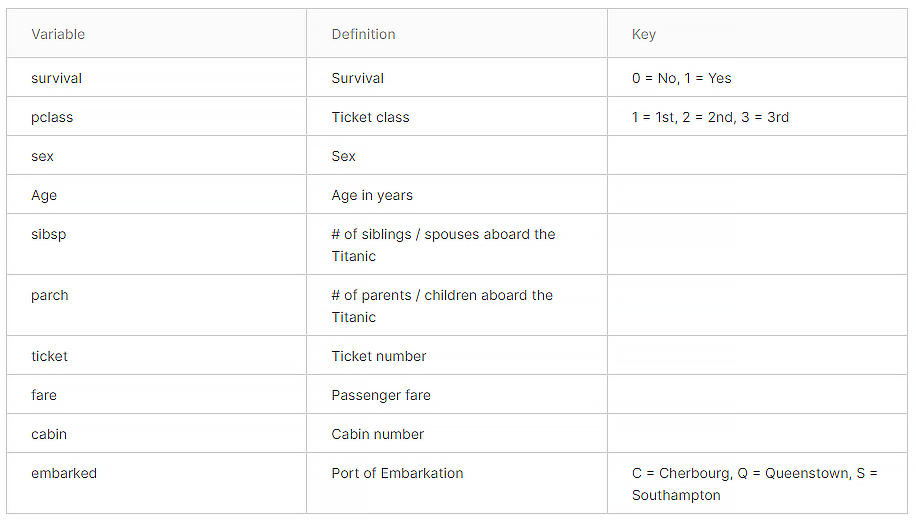

**Variable Notes**  <br>
**pclass**: A proxy for socio-economic status (SES) <br>
1st = Upper <br>
2nd = Middle <br>
3rd = Lower <br>

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way... <br>
Sibling = brother, sister, stepbrother, stepsister <br>
Spouse = husband, wife (mistresses and fiancés were ignored) <br>

**parch**: The dataset defines family relations in this way... <br>
Parent = mother, father <br>
Child = daughter, son, stepdaughter, stepson <br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
print('Rows and Columns in train dataset:', train.shape)

Rows and Columns in train dataset: (100000, 12)


In [3]:
print('The number of unique values in columns in train dataset')
for col in train.columns:
    print(f'{col}: {len(pd.unique(train[col]))}')

The number of unique values in columns in train dataset
PassengerId: 100000
Survived: 2
Pclass: 3
Name: 92144
Sex: 2
Age: 174
SibSp: 7
Parch: 8
Ticket: 75332
Fare: 15936
Cabin: 26993
Embarked: 4


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In the train set:

- 42.7% people survived.
- 50% of passengers were in between the age of 25 to 53.
- Unique values in Name column is not equal to the number of passengers. This might be an indication that there could be duplicate names. Otherwise, in a rare case passengers with identical names.

# Data quality assessment

## Duplicates

In [5]:
# There are no duplicates
len(train) - len(train.drop_duplicates())

0

## Missing values

In [6]:
print('Missing values per columns in train dataset')
for col in train.columns:
    print(f'{col}: {train[col].isnull().sum()}')

Missing values per columns in train dataset
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 3292
SibSp: 0
Parch: 0
Ticket: 4623
Fare: 134
Cabin: 67866
Embarked: 250


In [7]:
# Working with missing values
train['Age'] = train['Age'].fillna(train.groupby('Pclass')['Age'].transform('median'))
train['Fare'] = train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'))

embark_mapping = {"S" : "Southampton", "C" : "Cherbourg",  "Q" : "Queenstown", np.nan : "Not Embarked"}
train = train.replace({"Embarked": embark_mapping})

train['Cabin'] = train['Cabin'].fillna("No Cabin")
train['Cabin'] = train['Cabin'].str[0]

train.drop('PassengerId', axis=1, inplace=True)
#train.drop('Ticket', axis=1, inplace=True)

In [8]:
# New features
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['HasFamily'] = train.apply(lambda x: "With family" if x.FamilySize != 1 else "Alone", axis=1)

bins = [0, 5, 17, 30, 50, 100]
labels = ["Baby", "Children", "Young Adult", "Middle Aged", "Senior"]
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels) 

bins = [0, 25, 90, 150, np.inf]
labels = ["Low", "Middle", "High", "Very high"]
train['FareGroup'] = pd.cut(train['Fare'], bins=bins, labels=labels) 

bins = [0, 1, 4, 7, np.inf]
labels = ["Single", "Usual", "Big", "Very big"]
train['FamilyGroup'] = pd.cut(train['FamilySize'], bins=bins, labels=labels) 

train['LastName'] = train['Name'].str.split(',', expand = True)[0]
train['FirstName'] = train['Name'].str.split(',', expand = True)[1]

In [9]:
# Conversion to Categorical
col_cat = ['Name', 'Sex', 'HasFamily', 'Cabin', 'Embarked', 'AgeGroup', 'FareGroup', 'FirstName', 'LastName', 'FamilyGroup']
for feature in col_cat:
    train[feature] = pd.Categorical(train[feature])

## Find outliers

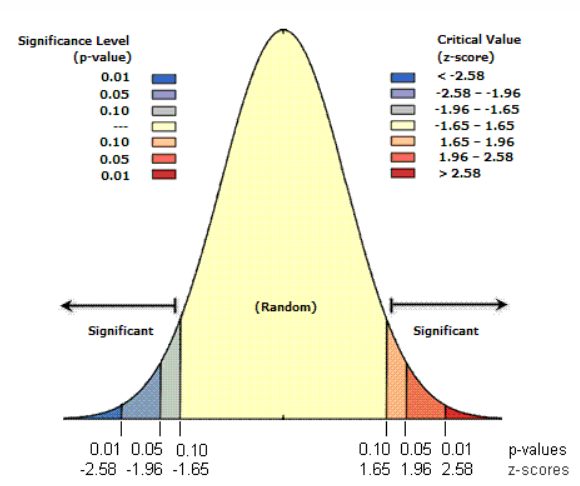

In [10]:
# z-score for Fare
z = np.abs(stats.zscore(train['Fare'], nan_policy='omit'))
train[z > 3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,HasFamily,AgeGroup,FareGroup,FamilyGroup,LastName,FirstName
63,0,1,"Moreno, Carla",female,36.0,0,2,SC/Paris 231091,473.49,A,Cherbourg,3,With family,Middle Aged,Very high,Usual,Moreno,Carla
99,1,1,"Kanter, Betty",female,59.0,0,0,48662,278.56,C,Cherbourg,1,Alone,Senior,Very high,Single,Kanter,Betty
108,1,1,"Truman, Linda",female,61.0,0,0,PC 11553,296.27,C,Cherbourg,1,Alone,Senior,Very high,Single,Truman,Linda
322,1,1,"Gearhart, Josephine",female,49.0,0,0,PC 176663,260.99,B,Southampton,1,Alone,Middle Aged,Very high,Single,Gearhart,Josephine
450,1,1,"Conner, Lori",female,58.0,0,1,425663,479.20,C,Cherbourg,2,With family,Senior,Very high,Usual,Conner,Lori
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99605,1,1,"Anderson, Marsha",female,51.0,0,1,PC 11488,258.59,B,Cherbourg,2,With family,Senior,Very high,Usual,Anderson,Marsha
99606,1,1,"Martinez, Stacey",female,10.0,0,0,PC 30071,256.69,C,Southampton,1,Alone,Children,Very high,Single,Martinez,Stacey
99660,1,1,"Avila, Dawn",female,31.0,1,1,10179,387.48,B,Southampton,3,With family,Middle Aged,Very high,Usual,Avila,Dawn
99900,0,2,"Tatum, Darius",male,30.0,0,0,STON/O 181069,460.81,N,Southampton,1,Alone,Young Adult,Very high,Single,Tatum,Darius


In [11]:
train[train.Fare >= 200]['Name'].count() 

4859

In [12]:
train[z > 3]['Pclass'].value_counts()

1    1990
3     188
2     171
Name: Pclass, dtype: int64

In [13]:
train.drop(train[(z > 3) & (train.Pclass == 3)].index, axis=0, inplace=True)

**Conclusion:** The columns having null values are: Age, Ticket, Fare, Cabin, Embarked.  Most of the missing value come from Cabin feature. It was decided to remove the columns PassengerId and Ticket due to low information content. The missing values for Age and Fare are replaced by the median for each Pclass. Missing values for columns Cabin and Embarked was filled with new separate category. 

For less than 5% of passengers fare was more than 200. z-scores identified 2349 passengers as outliers. This is due to the high fare for the 1st class. We will remove outliers with a high fare only for 3rd class passengers.


# Data exploration

## Age

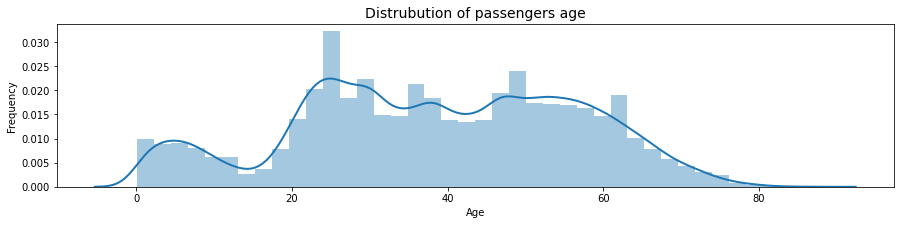

In [14]:
plt.figure(figsize=(15, 3))
sns.distplot(train.Age, kde_kws={"lw": 2}, bins=40)
plt.title('Distrubution of passengers age', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Frequency');

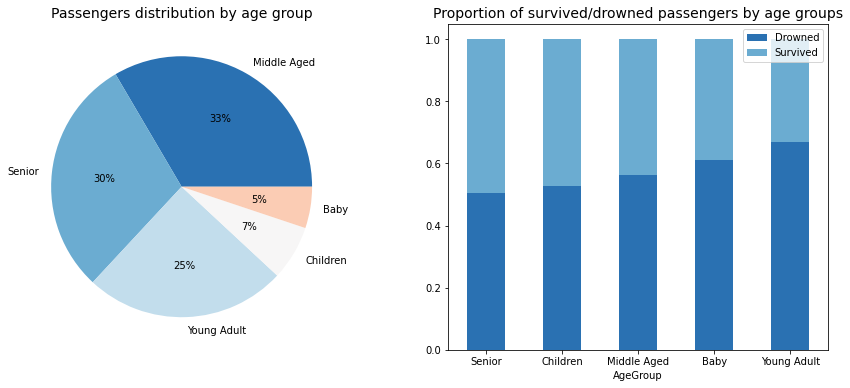

In [15]:
fig = plt.figure(figsize=(15, 6))
palette = sns.color_palette("RdBu_r", 7)

ax1 = fig.add_subplot(121)
plt.title('Passengers distribution by age group', fontsize=14)
labels = train.AgeGroup.value_counts().index.to_list()
plt.pie(train.AgeGroup.value_counts(), labels=labels, colors=palette, autopct='%.0f%%')

ax2 = fig.add_subplot(122)
plt.title('Proportion of survived/drowned passengers by age groups', fontsize=14)
agegroup = train.groupby('AgeGroup')['Survived'].value_counts(normalize=True).unstack()
agegroup = agegroup.sort_values(by=1, ascending=False)
agegroup.plot.bar(stacked='True', color=palette, ax=ax2)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

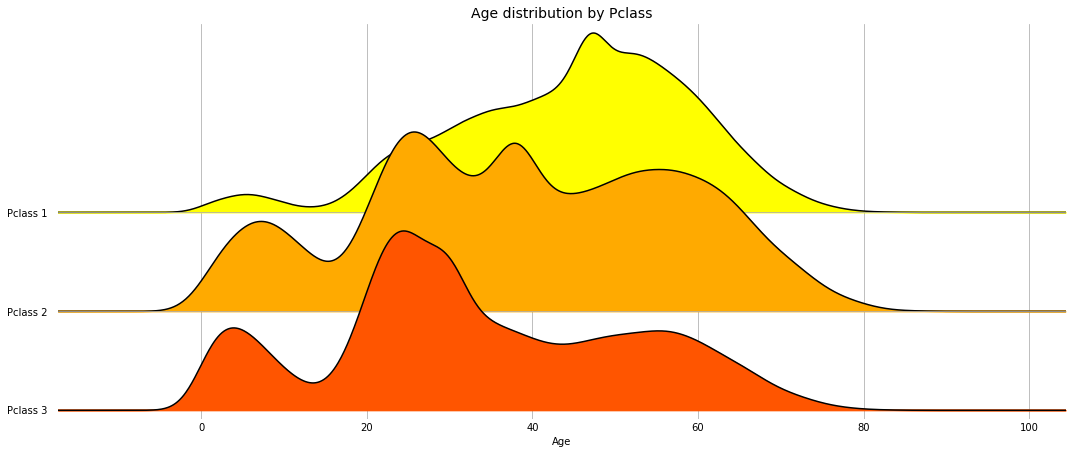

In [16]:
joy_labels = ['Pclass ' + str(Pclass) for Pclass in np.sort(train['Pclass'].unique())]
fig, ax = joypy.joyplot(train, by='Pclass', column="Age", ylim='own', 
                          labels=joy_labels, grid=True,
                          colormap=cm.autumn_r, overlap=2, figsize=(15, 6))
plt.xlabel('Age')
plt.title('Age distribution by Pclass', fontsize=14);

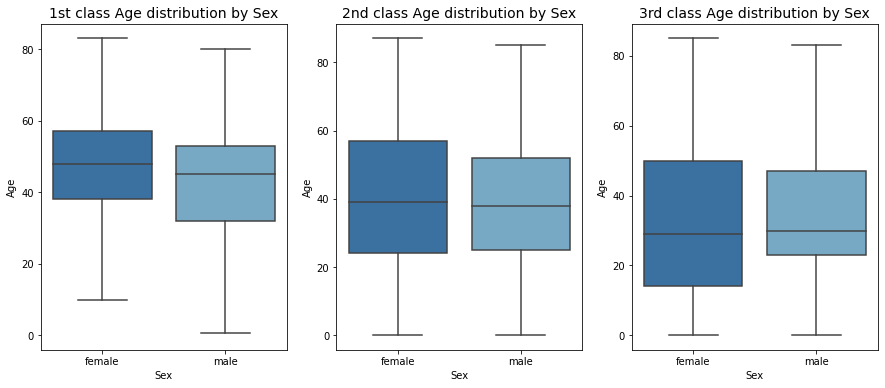

In [17]:
plt.figure(figsize=(15, 6))
palette = sns.color_palette("RdBu_r", 7)

plt.subplot(1, 3, 1)
sns.boxplot(x = 'Sex', y = 'Age', data = train[train.Pclass == 1], palette = palette, fliersize = 0)
plt.title('1st class Age distribution by Sex', fontsize=14)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'Sex', y = 'Age', data = train[train.Pclass == 2], palette = palette, fliersize = 0)
plt.title('2nd class Age distribution by Sex', fontsize=14)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'Sex', y = 'Age',  data = train[train.Pclass == 3], palette = palette, fliersize = 0)
plt.title('3rd class Age distribution by Sex', fontsize=14);

**Conclusion:** The oldest and the youngest passengers are female. Most popular age groups are young adult and senior. Most people who did not survive are young adult. Children and senior age groups have highest surviving rate. Highest average age of passengers is in 1st class, the lowest is in 3rd class.

## Cabin

*Picture for clarity.*

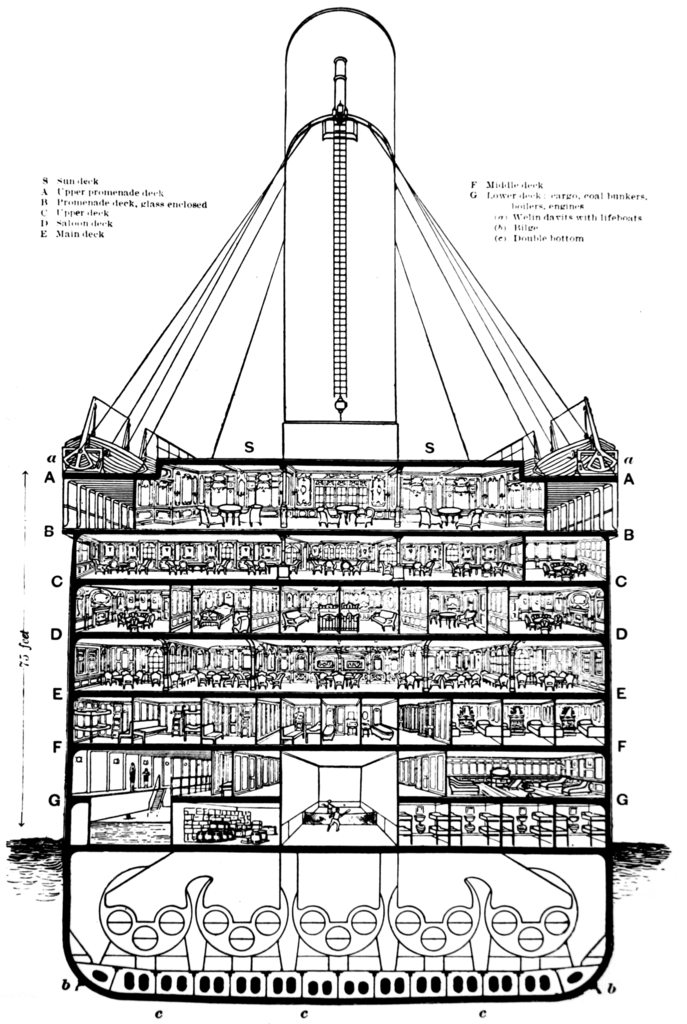

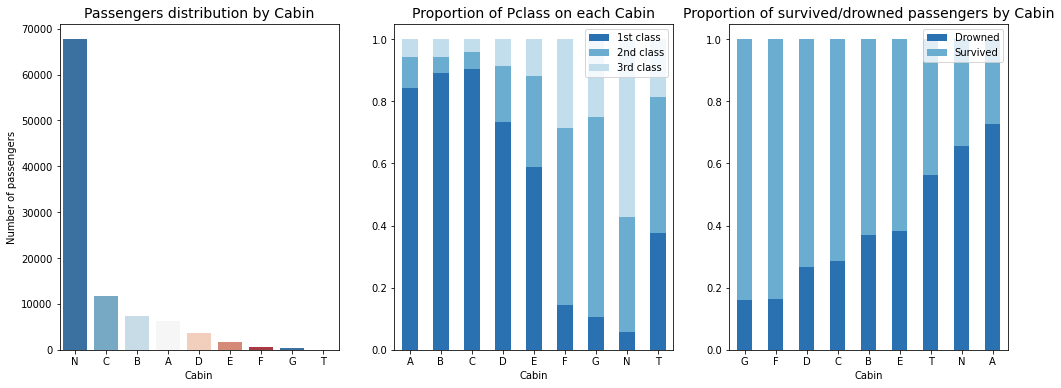

In [18]:
fig = plt.figure(figsize=(17, 6))

ax1 = fig.add_subplot(131)
sns.countplot(x = 'Cabin', data = train, palette = palette, order = train['Cabin'].value_counts().index, ax = ax1)
plt.title('Passengers distribution by Cabin', fontsize=14)
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
pclass = train.groupby('Cabin')['Pclass'].value_counts(normalize=True).unstack()
pclass.plot(kind='bar', stacked='True', color=palette, ax=ax2)
plt.legend(('1st class', '2nd class', '3rd class'))
plt.title('Proportion of Pclass on each Cabin', fontsize=14)
plt.xticks(rotation = False)

ax3 = fig.add_subplot(133)
cabin = train.groupby('Cabin')['Survived'].value_counts(normalize=True).unstack()
cabin = cabin.sort_values(by=1, ascending=False)
cabin.plot(kind='bar', stacked='True', color=palette, ax=ax3)
plt.title('Proportion of survived/drowned passengers by Cabin', fontsize=14)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

**Conclusion:** Most passengers don't have cabin numbers ('N'). The largest part of passengers with known cabin numbers were located on the 'C' cabin and had 1st class ticket. 'C' cabin is fourth by a percentage of the survivor. The highest surviving rate had passengers from cabin 'G'. Cabin 'A 'was the closest to the deck with lifeboats, but it is the last in surviving rate.

## Family (SibSp, Parch)

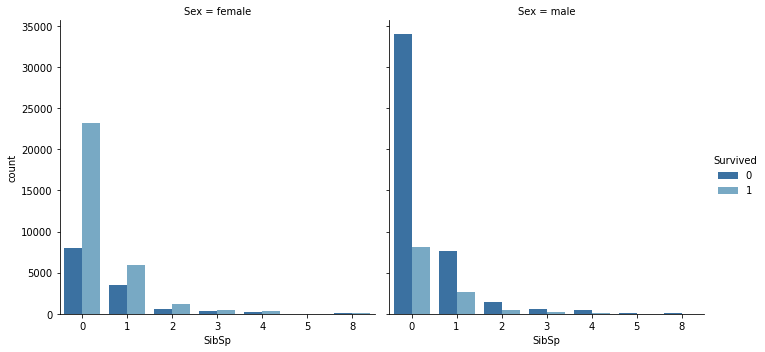

In [19]:
sns.catplot(x = 'SibSp', hue = 'Survived', col = 'Sex', kind = 'count', data = train , palette=palette);

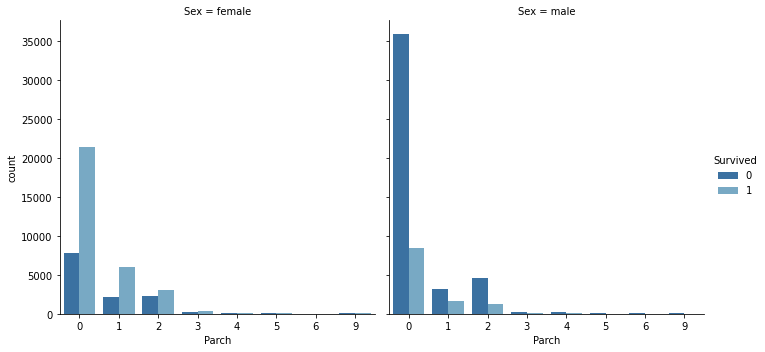

In [20]:
sns.catplot(x = 'Parch', hue = 'Survived', col = 'Sex', kind = 'count', data = train , palette=palette);

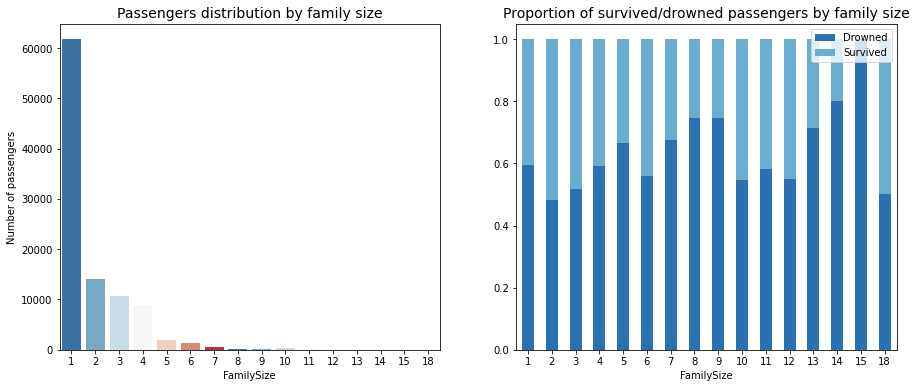

In [21]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
sns.countplot(train['FamilySize'], palette=palette, ax=ax1)
plt.title('Passengers distribution by family size', fontsize=14)
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(122)
familysize = train.groupby('FamilySize')['Survived'].value_counts(normalize=True).unstack()
familysize.plot(kind='bar', color=palette, stacked='True', ax=ax2)
plt.title('Proportion of survived/drowned passengers by family size', fontsize=14)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

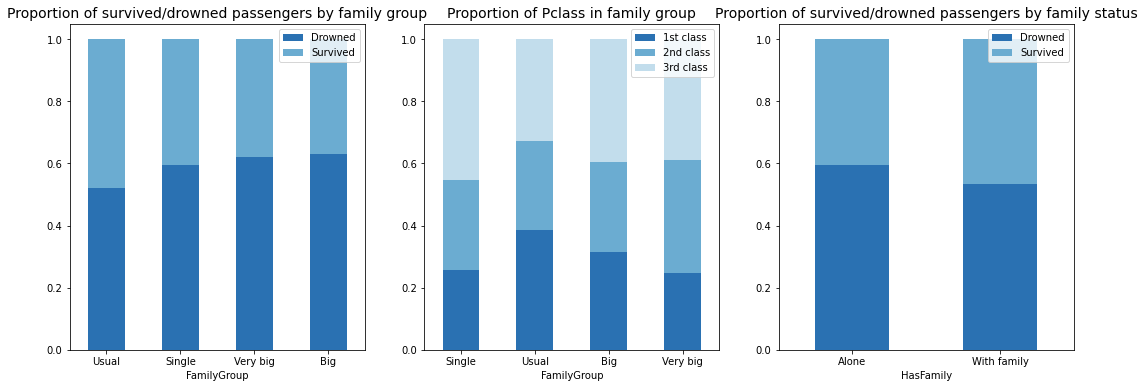

In [22]:
fig = plt.figure(figsize = (18, 6))

ax1 = fig.add_subplot(131)
familygroup = train.groupby('FamilyGroup')['Survived'].value_counts(normalize=True).unstack()
familygroup = familygroup.sort_values(by=1, ascending=False)
familygroup.plot(kind='bar', stacked='True', color=palette, ax=ax1)
plt.title('Proportion of survived/drowned passengers by family group', fontsize=14)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation=False)

ax2 = fig.add_subplot(132)
familygroup = train.groupby('FamilyGroup')['Pclass'].value_counts(normalize=True).unstack()
familygroup.plot(kind='bar', stacked='True', color=palette, ax=ax2)
plt.legend(('1st class', '2nd class', '3rd class'))
plt.title('Proportion of Pclass in family group', fontsize=14)
plt.xticks(rotation=False);

ax3 = fig.add_subplot(133)
hasfamily = train.groupby('HasFamily')['Survived'].value_counts(normalize=True).unstack()
hasfamily.plot(kind='bar', stacked='True', color=palette, ax=ax3)
plt.legend(('Drowned', 'Survived'))
plt.title('Proportion of survived/drowned passengers by family status', fontsize=14)
plt.xticks(rotation=False);

**Conclusion:** Most of the passengers were traveling alone, percent of survivals not very hight. The biggest proportion of survived passengers in group of people who had 2 family members on board. We can observe that the percentage of survivors in families of 2, 3 or 4 people is greater than in alone, then the percentage of survivors decreases as the family size increases. The biggest proportion of the 1st class in the usual size of the family and the proportion of survivors in the usual family is the biggest. The chance of survival if you are with family is greater than if you are alone.

## Sex, Pclass

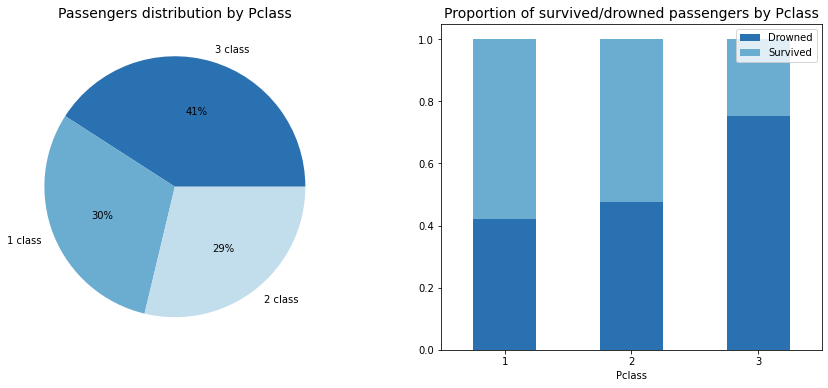

In [23]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
plt.title('Passengers distribution by Pclass', fontsize=14)
labels = [str(i) + ' class' for i in train.Pclass.value_counts().index.to_list()]
plt.pie(train.Pclass.value_counts(), labels=labels, colors=palette, autopct='%.0f%%')

ax2 = fig.add_subplot(122)
plt.title('Proportion of survived/drowned passengers by Pclass', fontsize=14)
pclass = train.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack()
pclass = pclass.sort_values(by=1, ascending=False)
pclass.plot.bar(stacked='True', color=palette, ax=ax2)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

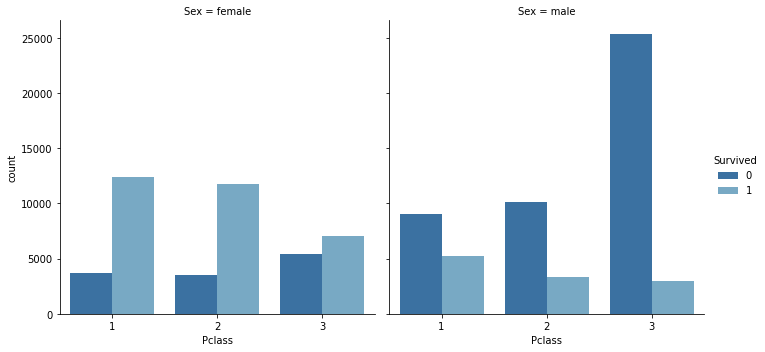

In [24]:
sns.catplot(x = 'Pclass', hue = 'Survived', col = 'Sex', kind = 'count', data = train , palette=palette);

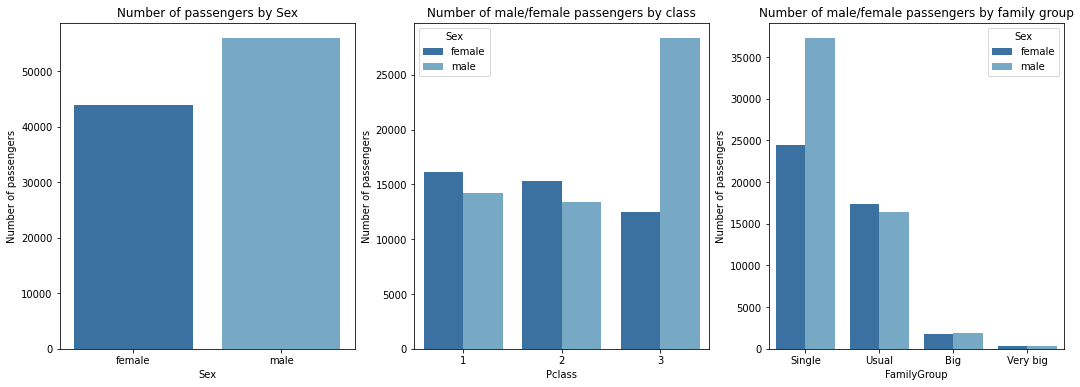

In [25]:
plt.figure(figsize=(18,6))

plt.subplot (1,3,1)
sns.countplot(train['Sex'], palette=palette)
plt.title('Number of passengers by Sex')
plt.ylabel('Number of passengers')

plt.subplot (1,3,2)
sns.countplot( x = 'Pclass', data = train, hue = 'Sex', palette=palette)
plt.title('Number of male/female passengers by class')
plt.ylabel('Number of passengers')

plt.subplot (1,3,3)
sns.countplot( x = 'FamilyGroup', data = train, hue = 'Sex', order = train['FamilyGroup'].value_counts().index, palette=palette)
plt.title('Number of male/female passengers by family group')
plt.ylabel('Number of passengers');

**Conclusion:** Most people are male. Female has a lot higher rate of survival compared with male. People boarding on class 3 has a low chance of survival whilst class 1 has the highest chance of survival. Most of the male passengers of 3rd class drowned, and the female on board almost all survived. There were overall more males than females on board, it is fair for each ticket class, but in the 3rd class number of males more than twice bigger than females. Most male and female passengers traveled without family members.

## Embarked

*Picture for clarity.*

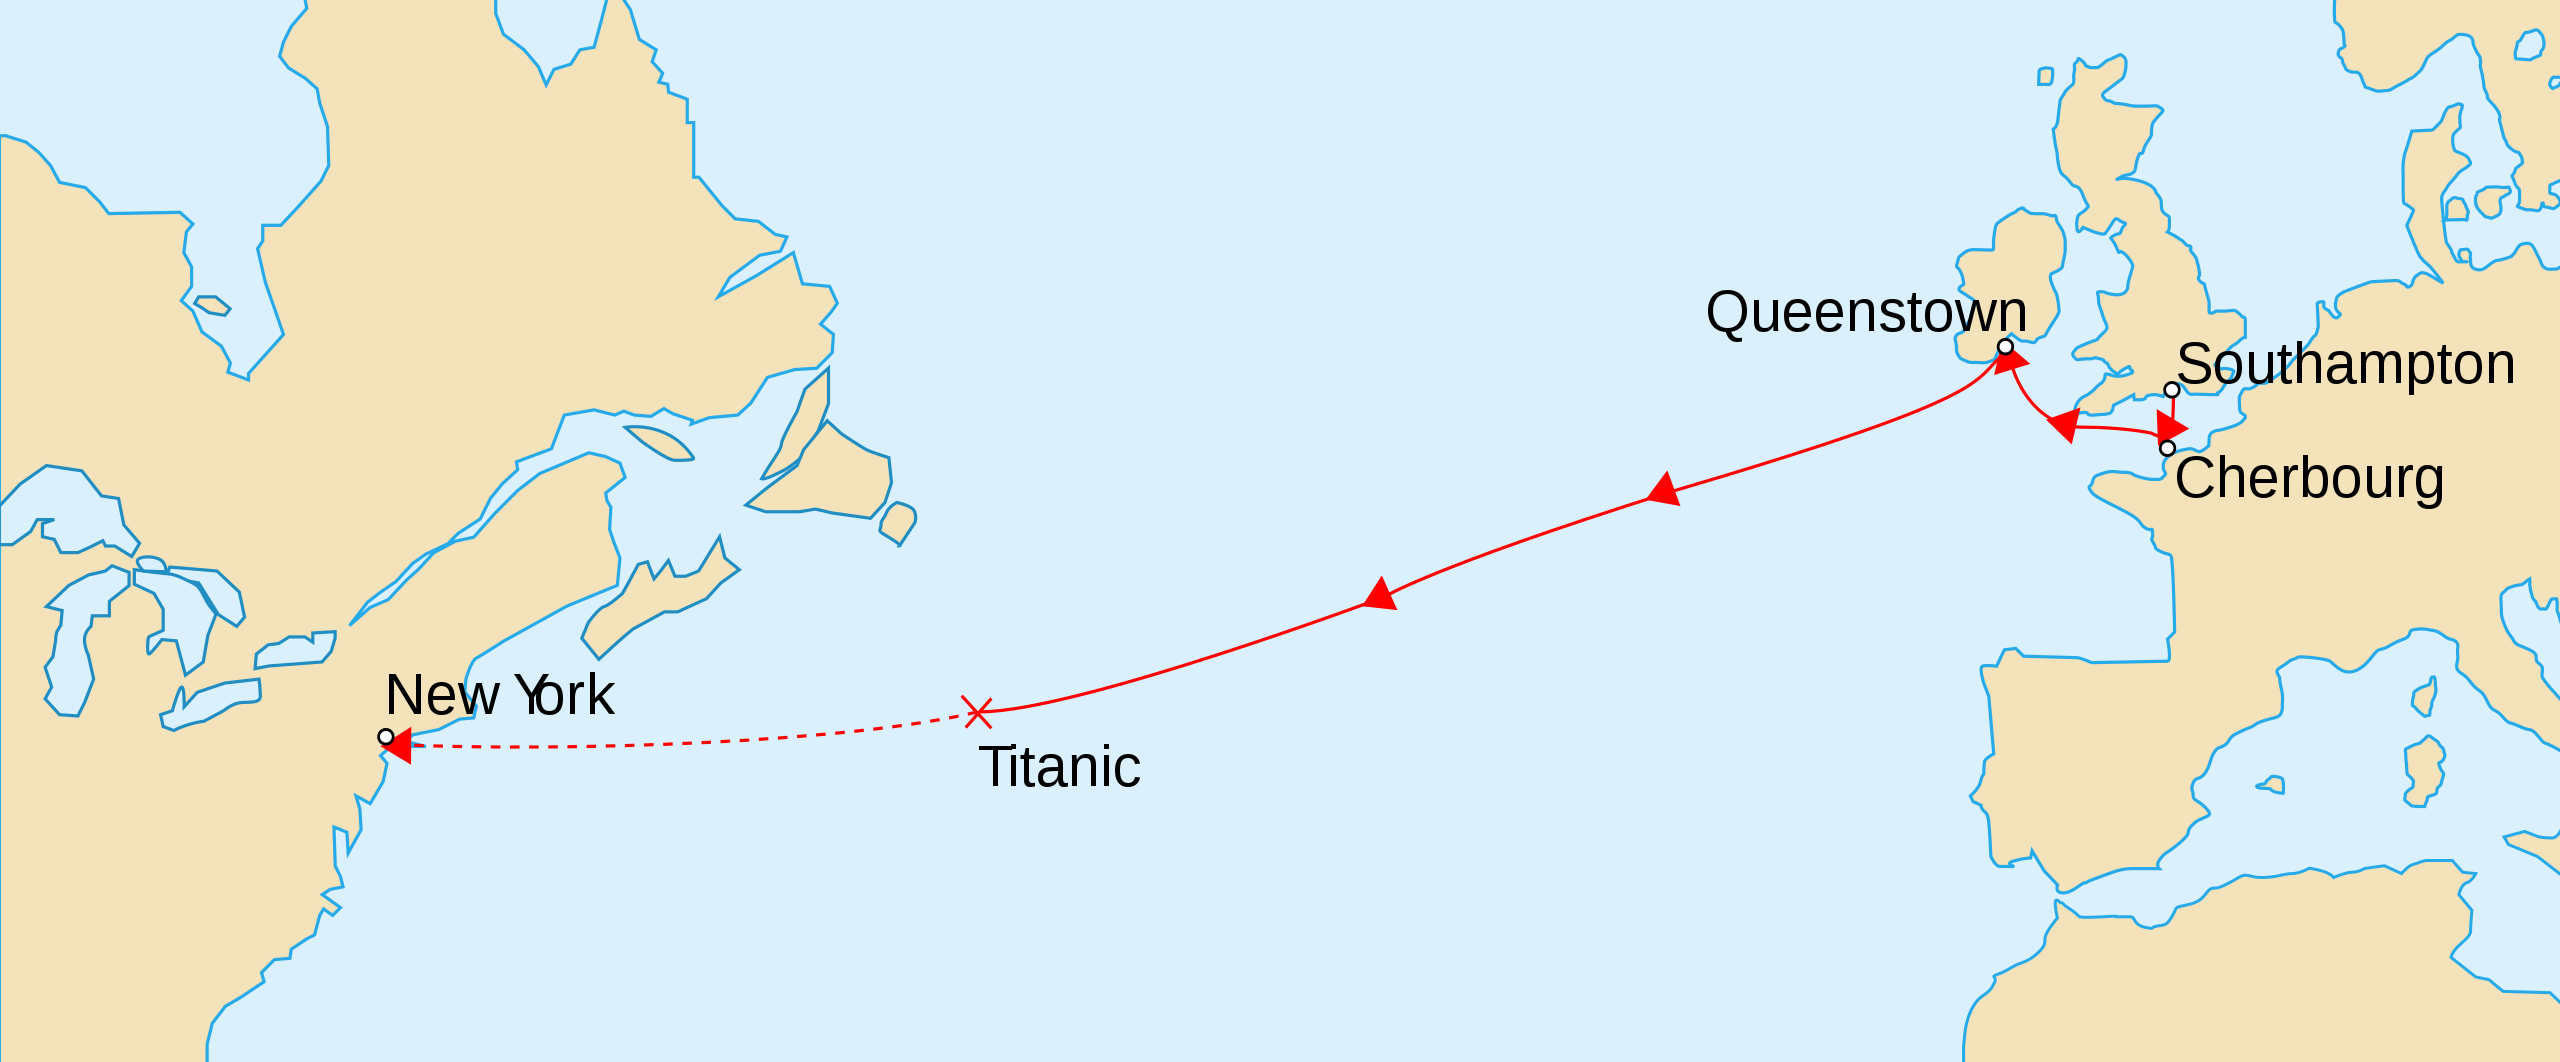

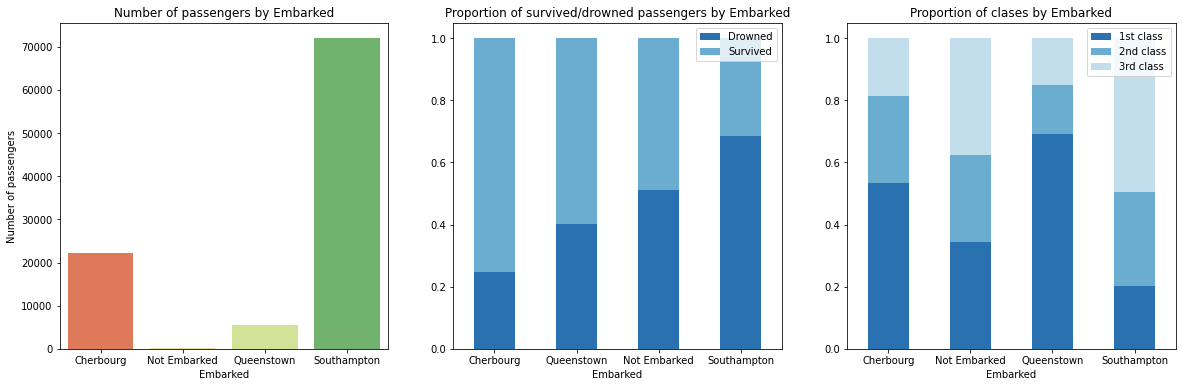

In [26]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
sns.countplot(train['Embarked'], palette='RdYlGn', ax=ax1)
plt.title('Number of passengers by Embarked')
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
embarked = train.groupby('Embarked')['Survived'].value_counts(normalize=True)
embarked = embarked.unstack().sort_values(by=1, ascending=False)
embarked.plot(kind='bar', stacked='True', color=palette, ax=ax2)
plt.title('Proportion of survived/drowned passengers by Embarked')
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation=False)

ax3 = fig.add_subplot(133)
embarked = train.groupby('Embarked')['Pclass'].value_counts(normalize=True)
embarked = embarked.unstack().sort_index()
embarked.plot(kind='bar', stacked='True', color=palette, ax=ax3)
plt.legend(('1st class', '2nd class', '3rd class'))
plt.title('Proportion of clases by Embarked')
plt.xticks(rotation=False);

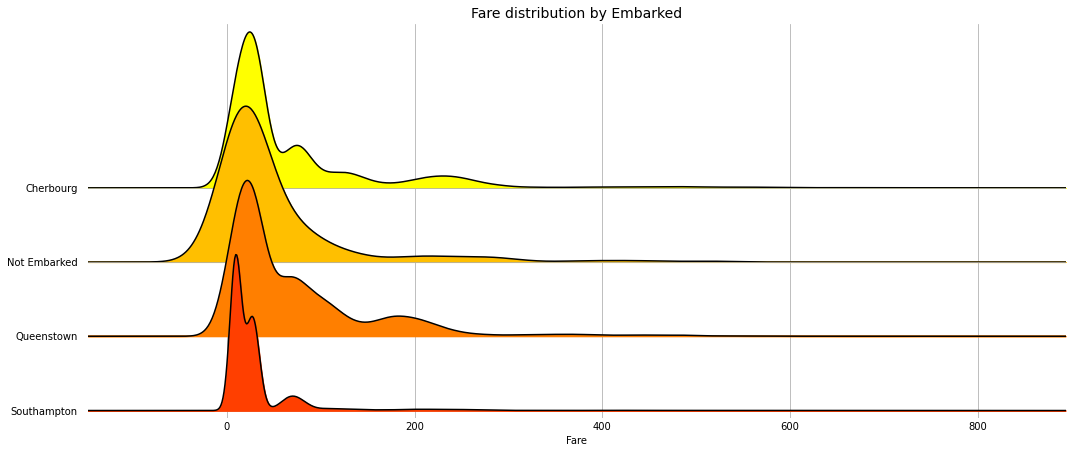

In [27]:
fig, ax = joypy.joyplot(train, by='Embarked', column="Fare", ylim='own', 
                        grid=True, colormap=cm.autumn_r, overlap=2, figsize=(15, 6))

plt.xlabel('Fare')
plt.title('Fare distribution by Embarked', fontsize=14);

In [28]:
pd.DataFrame(train.groupby('Embarked')['Fare'].describe())

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
Cherbourg,22157.0,71.042392,92.276781,1.51,22.4900,31.210,80.560,744.46
Not Embarked,250.0,50.224600,75.699028,2.16,10.8825,26.575,49.545,510.51
Queenstown,5412.0,72.611691,82.085504,2.29,23.5275,31.390,96.740,744.66
Southampton,71993.0,32.468382,53.050417,0.68,9.3700,15.900,29.860,727.65


**Conclusion:** Most people boarded at Southampton. People boarded at Cherbourg has a highest rate of survival whilst people from Southampton has the lowest rate of survival People from Cherbourg mostly the class 1 whilst people from Southampton mostly the class 3. The vast majority of passengers from Queenstown are 1st class.

Distribution fare among passengers from Cherbourg or Queenstown very similar. It makes science - most passengers 1st class. The smallest variation in the fare of passengers who boarded at Southampton. Also, the average fare of these passengers is the lowest.

## Fare

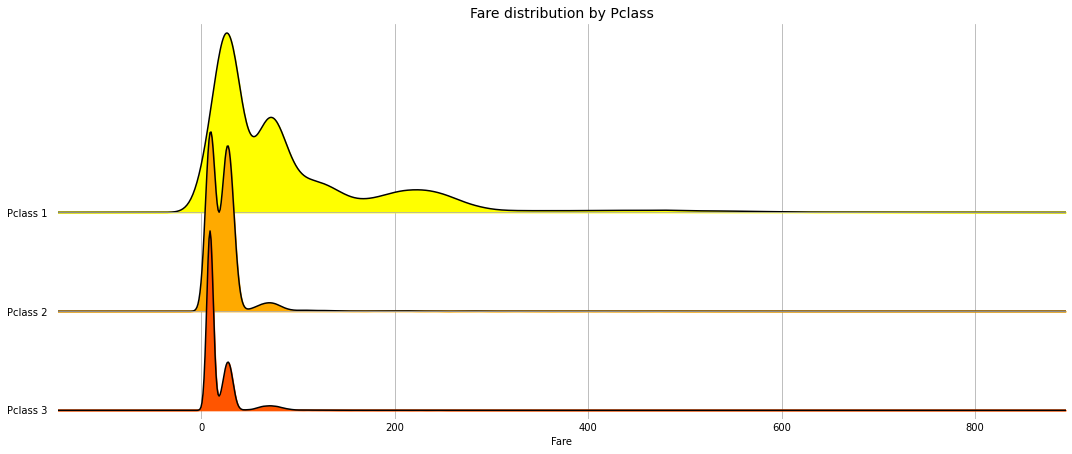

In [29]:
joy_labels = ['Pclass ' + str(Pclass) for Pclass in np.sort(train['Pclass'].unique())]
fig, ax = joypy.joyplot(train, by='Pclass', column="Fare", ylim='own', 
                        labels=joy_labels, grid=True,
                        colormap=cm.autumn_r, overlap=2, figsize=(15, 6))
plt.xlabel('Fare')
plt.title('Fare distribution by Pclass', fontsize=14);

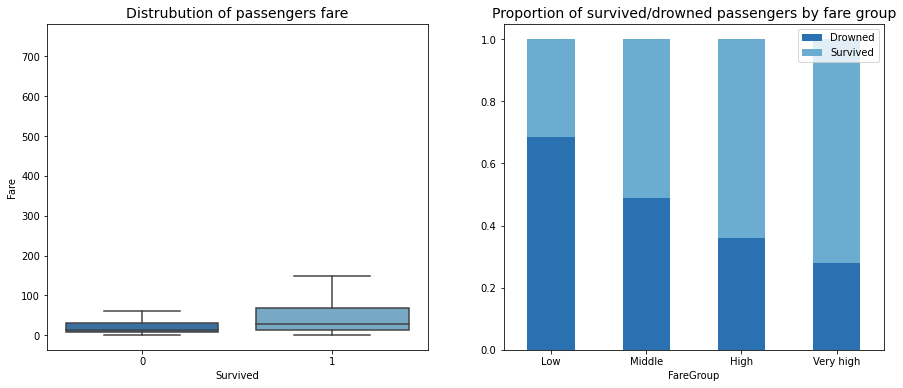

In [30]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
sns.boxplot(x='Survived', y='Fare', data=train, palette=palette, fliersize=0)
plt.title('Distrubution of passengers fare', fontsize= 14)
plt.xlabel('Survived')
plt.ylabel('Fare')

ax2 = fig.add_subplot(122)
faregroup = train.groupby('FareGroup')['Survived'].value_counts(normalize=True).unstack()
faregroup.plot(kind='bar', color=palette, stacked='True', ax=ax2)
plt.title('Proportion of survived/drowned passengers by fare group', fontsize=14)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

**Conclusion:** We can observe that the distribution of fare for the 2nd and 3rd class is very similar. The distribution of 1st class prices is very different, has a larger spread, and on average fare are higher. Also looks like the more passenger paid, the more chances to survive he had.

## Other

In [48]:
ticket_group = train.groupby('Ticket')['Name'].count().reset_index()
ticket_group[ticket_group.Name > 1]

,Ticket,Name
2,10002,2
3,10003,5
5,10005,3
6,10006,2
8,10009,2
...,...,...
73446,STON/O 436950,2
73753,STON/O2.,21
74035,STON/O2. 422140,2
74221,W./C.,53


In [53]:
train[train.Ticket == '10003']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,HasFamily,AgeGroup,FareGroup,FamilyGroup,LastName,FirstName
18640,1,3,"Sampson, Calvin",male,7.0,1,2,10003,38.17,N,Cherbourg,4,With family,Children,Middle,Usual,Sampson,Calvin
24266,1,1,"Strutz, Crista",female,31.0,0,0,10003,34.97,C,Cherbourg,1,Alone,Middle Aged,Middle,Single,Strutz,Crista
61118,0,2,"Day, Trinidad",female,21.0,0,0,10003,4.87,N,Southampton,1,Alone,Young Adult,Low,Single,Day,Trinidad
63313,0,3,"Geraci, Louis",male,41.0,1,0,10003,19.62,N,Southampton,2,With family,Middle Aged,Low,Usual,Geraci,Louis
73205,0,1,"Reiser, Dennis",male,67.0,0,0,10003,22.02,C,Southampton,1,Alone,Senior,Low,Single,Reiser,Dennis


In [32]:
train[(train.Survived == 0) & (train.Sex == 'male')]['FirstName'].value_counts()[:10]

 John       1667
 James      1652
 Robert     1552
 Michael    1321
 William    1212
 David      1194
 Richard     900
 Charles     731
 Thomas      683
 Joseph      670
Name: FirstName, dtype: int64

In [33]:
train[(train.Survived == 0) & (train.Sex == 'female')]['FirstName'].value_counts()[:10]

 Mary         383
 Patricia     147
 Elizabeth    139
 Barbara      136
 Linda        124
 Margaret     115
 Karen        108
 Susan        108
 Lisa         106
 Maria        105
Name: FirstName, dtype: int64

In [34]:
train[(train.Survived == 1) & (train.Sex == 'male')]['FirstName'].value_counts()[:10]

 James      449
 John       411
 Robert     391
 Michael    351
 William    305
 David      300
 Richard    211
 Charles    195
 Thomas     181
 Joseph     162
Name: FirstName, dtype: int64

In [35]:
train[(train.Survived == 1) & (train.Sex == 'female')]['FirstName'].value_counts()[:10]

 Mary         881
 Barbara      364
 Patricia     363
 Linda        357
 Jennifer     338
 Elizabeth    318
 Susan        285
 Lisa         266
 Maria        265
 Helen        258
Name: FirstName, dtype: int64

# Summary

The main conclusions were made throughout the study. But it's worth summarizing. If we use a naive approach and consider all the parameters separately, then young female of 1st class on the level G with a moderate number of relatives on board, who paid a large fare and boarded at Cherbourg has a better chance of survival. It is obvious that impossible determine will survive or drown passenger by 100 percent based on the individual factors, since the human factor and the unpredicted emergensy were involved in the rescue process.